# EE 519 — Frequency-domain Analysis of Speech (Lectures 7-8)
## Notebook — Wideband vs Narrowband Spectrograms (with clip set)

---
## What you will do
1. Choose a set of clips from your manifest.
2. Compute wideband spectrogram (short window).
3. Compute narrowband spectrogram (long window).
4. Compare how voiced/unvoiced/bursts appear.
5. Write final “what I learned” for Lecture 7.


### How to use Lecture 7 notebooks in-class (hands-on)
**Goal:** build intuition for STFT by repeatedly analyzing *your own* recordings under different window/hop choices.

**Workflow for the whole lecture**
1. Record multiple clips once (Notebook 7.0) and they are saved + registered in a manifest.
2. Every later notebook reuses the same recordings (no re-recording needed).
3. Always pick **meaningful time regions** (vowel middle, fricative middle, stop burst, silence) — not just the first frames.

**Where things are saved**
- Audio: `EE519_L7_Project/audio/`
- Figures: `EE519_L7_Project/figures/`
- Manifest: `EE519_L7_Project/manifest.json`

**Pro tip:** keep filenames consistent across the class:  
`vowel_a_soft`, `vowel_a_loud`, `sentence_fast`, `sentence_slow`, `fricative_s`, `stop_pa`, `silence_room`


### ✅ Clip checklist (quick self-check)
By the end of Notebook 7.0 you should have **at least 8 clips** registered in your manifest:

**Required categories**
- **Vowel**: one steady vowel (e.g., /a/ or /i/) — *soft* and *loud*
- **Sentence**: one short sentence — *slow* and *fast*
- **Fricative**: sustained /s/ or /sh/
- **Stop**: repeated /pa pa pa/ or /ta ta ta/ (captures bursts + closures)
- **Silence**: 2–3 seconds of room silence

If you're missing any, record them now in 7.0 (it takes 2 minutes and makes later analysis much clearer).


## 0) Setup


#### 🎙️ Before you record: tips for clean data
- Sit ~15–25 cm from the mic.
- Avoid tapping the laptop/desk (low-frequency thumps).
- Record at least **2–3 seconds** per clip.
- For vowel: hold a steady pitch (don’t glide).
- For sentence: keep content the same across slow/fast versions.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


In [1]:
import os, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import get_window, chirp
from scipy.io import wavfile
from IPython.display import Audio, display

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["axes.grid"] = True

# ---------------------------
# Project folders (auto-create)
# ---------------------------
PROJECT_DIR = Path("EE519_L7_Project")
AUDIO_DIR   = PROJECT_DIR / "audio"
FIG_DIR     = PROJECT_DIR / "figures"
RESULTS_DIR = PROJECT_DIR / "results"
for d in [PROJECT_DIR, AUDIO_DIR, FIG_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = PROJECT_DIR / "manifest.json"

def _to_float_mono(y):
    """Convert audio array to float32 mono in [-1, 1]."""
    y = np.asarray(y)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if np.issubdtype(y.dtype, np.integer):
        y = y.astype(np.float32) / (np.iinfo(y.dtype).max + 1e-12)
    else:
        y = y.astype(np.float32)
    mx = np.max(np.abs(y)) + 1e-12
    if mx > 1.0:
        y = y / mx
    return y

def load_wav(path):
    fs, y = wavfile.read(path)
    return fs, _to_float_mono(y)

def save_wav(path, fs, y):
    """Save float audio in [-1,1] to 16-bit PCM WAV."""
    y16 = np.clip(y, -1.0, 1.0)
    y16 = (y16 * 32767).astype(np.int16)
    wavfile.write(str(path), fs, y16)

def play_audio(y, fs, label=None):
    if label:
        print(label)
    display(Audio(y, rate=fs))

def plot_waveform(y, fs, title="Waveform", tlim=None, save_as=None):
    t = np.arange(len(y)) / fs
    plt.figure(figsize=(12, 3))
    plt.plot(t, y, linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def mag_spectrum(y, fs, nfft=None, db=True):
    y = np.asarray(y, dtype=np.float32)
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(len(y))))
    Y = fft(y, n=nfft)
    f = fftfreq(nfft, d=1/fs)
    idx = f >= 0
    mag = np.abs(Y[idx])
    if db:
        mag = 20*np.log10(mag + 1e-10)
    return f[idx], mag

def plot_spectrum(y, fs, title="Magnitude Spectrum", fmax=None, nfft=None, db=True, save_as=None):
    f, mag = mag_spectrum(y, fs, nfft=nfft, db=db)
    plt.figure(figsize=(12, 3))
    plt.plot(f, mag, linewidth=1)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)" if db else "Magnitude")
    plt.title(title)
    if fmax is not None:
        plt.xlim(0, fmax)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def rms(y):
    y = np.asarray(y, dtype=np.float32)
    return float(np.sqrt(np.mean(y**2) + 1e-12))

def add_white_noise(y, snr_db, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y, dtype=np.float32)
    sig_pwr = np.mean(y**2) + 1e-12
    noise_pwr = sig_pwr / (10**(snr_db/10))
    noise = rng.standard_normal(len(y), dtype=np.float32) * np.sqrt(noise_pwr)
    return y + noise

def select_segment(y, fs, start_s, end_s):
    s = int(start_s*fs); e = int(end_s*fs)
    s = max(0, min(s, len(y)))
    e = max(0, min(e, len(y)))
    if e <= s:
        raise ValueError("end_s must be > start_s and within signal duration.")
    return y[s:e]

# ---------------------------
# Recording utilities
# ---------------------------
SOUNDDEVICE_OK = False
try:
    import sounddevice as sd
    SOUNDDEVICE_OK = True
except Exception:
    SOUNDDEVICE_OK = False

def record_audio(seconds=3.0, fs=16000, channels=1):
    if not SOUNDDEVICE_OK:
        raise RuntimeError("sounddevice not available. Upload WAVs or install sounddevice locally.")
    print(f"Recording {seconds:.1f}s at {fs} Hz... (speak now)")
    y = sd.rec(int(seconds*fs), samplerate=fs, channels=channels, dtype='float32')
    sd.wait()
    y = _to_float_mono(y)
    print("Done. RMS:", rms(y))
    return fs, y

def load_manifest():
    if MANIFEST_PATH.exists():
        return json.loads(MANIFEST_PATH.read_text(encoding="utf-8"))
    return {"audio_clips": [], "notes": []}

def save_manifest(m):
    MANIFEST_PATH.write_text(json.dumps(m, indent=2), encoding="utf-8")

def register_clip(name, path, fs, duration_s, tags=None, notes=""):
    m = load_manifest()
    m["audio_clips"].append({
        "name": name,
        "path": str(path),
        "fs": fs,
        "duration_s": float(duration_s),
        "tags": tags or [],
        "notes": notes
    })
    save_manifest(m)

def list_clips():
    m = load_manifest()
    if len(m["audio_clips"]) == 0:
        print("No clips registered yet.")
        return
    for i, c in enumerate(m["audio_clips"]):
        print(f"[{i}] {c['name']} | {c['duration_s']:.2f}s | fs={c['fs']} | tags={c['tags']} | file={c['path']}")


#### 🔧 Optional automated check (run anytime)
This cell reads your `manifest.json` and tells you what clip types you might be missing.


In [2]:
# Automated checklist (uses tags and/or names)
import json, re
from pathlib import Path

MANIFEST_PATH = Path("EE519_L7_Project/manifest.json")
if not MANIFEST_PATH.exists():
    print("No manifest found yet. Run Notebook 7.0 and record at least one clip.")
else:
    m = json.loads(MANIFEST_PATH.read_text(encoding="utf-8"))
    clips = m.get("audio_clips", [])
    names = [c.get("name","").lower() for c in clips]
    tags  = [set([t.lower() for t in c.get("tags",[])]) for c in clips]

    def has(pattern):
        rgx = re.compile(pattern)
        return any(rgx.search(n) for n in names)

    def has_tag(t):
        return any(t in tg for tg in tags)

    req = {
        "vowel (soft)": has("vowel") and (has("soft") or has_tag("soft")),
        "vowel (loud)": has("vowel") and (has("loud") or has_tag("loud")),
        "sentence (slow)": has("sentence") and (has("slow") or has_tag("slow")),
        "sentence (fast)": has("sentence") and (has("fast") or has_tag("fast")),
        "fricative": has("fric") or has("s_") or has_tag("fricative"),
        "stop/burst": has("stop") or has("pa") or has("ta") or has_tag("stop"),
        "silence": has("silence") or has_tag("silence"),
    }

    print("Manifest clips:", len(clips))
    missing = [k for k,v in req.items() if not v]
    if not missing:
        print("✅ Looks good — you have the recommended set.")
    else:
        print("⚠️ Missing (recommended):")
        for k in missing:
            print(" -", k)


Manifest clips: 12
⚠️ Missing (recommended):
 - vowel (loud)


#### 🔍 Before you run: what will change when you change window/hop?
- **Short window** → better **time** resolution, blurrier frequency (wideband look)
- **Long window** → better **frequency** resolution, blurrier time (narrowband look)
- **Smaller hop** → more overlap → smoother time evolution, more computation

**Common issues**
- If harmonics look “fuzzy”: increase window length (for narrowband).
- If stop bursts look “smeared”: shorten window (for wideband).


#### 🎯 Action: pick *meaningful* time points (not sequential frames)
Use the waveform/spectrogram to pick times from **different phenomena**:
- vowel middle
- fricative middle
- stop burst peak
- silence/closure

**Why?** You want to compare spectra across *sound types*, not across adjacent time slices.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


In [3]:
def stft_manual(y, fs, win_length_ms=25, hop_ms=10, window="hann", nfft=None, center=False):
    """Manual STFT (analysis only). Returns f (Hz), t (s), X (frames x freqs), meta."""
    y = np.asarray(y, dtype=np.float32)
    N = int(round(win_length_ms * 1e-3 * fs))
    H = int(round(hop_ms * 1e-3 * fs))
    if N <= 0 or H <= 0:
        raise ValueError("Window length and hop must be positive.")
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(N)))
    if nfft < N:
        raise ValueError("nfft must be >= N.")
    w = get_window(window, N, fftbins=True).astype(np.float32)
    if center:
        pad = N // 2
        y = np.pad(y, (pad, pad), mode="constant")
    num_frames = 1 + (len(y) - N) // H
    if num_frames <= 0:
        raise ValueError("Signal too short for chosen window length.")
    X = np.empty((num_frames, nfft//2 + 1), dtype=np.complex64)
    for m in range(num_frames):
        start = m * H
        frame = y[start:start+N] * w
        X[m, :] = np.fft.rfft(frame, n=nfft)
    f = np.fft.rfftfreq(nfft, d=1/fs)
    t = (np.arange(num_frames) * H) / fs
    meta = {"N": N, "H": H, "nfft": nfft, "window": window, "center": center,
            "win_length_ms": win_length_ms, "hop_ms": hop_ms}
    return f, t, X, meta

def spec_db(X):
    return 20*np.log10(np.abs(X) + 1e-10)

def plot_spectrogram_db(f, t, X, title="Spectrogram (dB)", fmax=None, vmin=None, vmax=None, save_as=None):
    S = spec_db(X)  # frames x freqs
    plt.figure(figsize=(12, 4.5))
    plt.imshow(S.T, origin="lower", aspect="auto",
               extent=[t[0], t[-1], f[0], f[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar(label="dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    if fmax is not None:
        plt.ylim(0, fmax)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def frame_index_from_time(t_sec, fs, hop_ms):
    H = int(round(hop_ms * 1e-3 * fs))
    return int(round(t_sec * fs / H))

def plot_frame_spectrum_from_stft(f, X, frame_idx, title="", fmax=None, save_as=None):
    mag_db = 20*np.log10(np.abs(X[frame_idx]) + 1e-10)
    plt.figure(figsize=(12,3))
    plt.plot(f, mag_db, linewidth=1)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title + f" (frame={frame_idx})")
    if fmax is not None:
        plt.xlim(0, fmax)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()


---
## 1) Choose clips (recommended: vowel + fricative + stop + sentence)
Run `list_clips()` and set indices.


#### ✅ Checkpoint: choose clips you can explain
Pick clips where you can point to regions like:
- steady **vowel** (voiced)  
- sustained **/s/** (unvoiced)  
- **stop burst** (brief)  
- **silence/closure** (low energy)

**In-class goal:** you should be able to say “this region is voiced/unvoiced/stop/silence” *before* plotting.


In [5]:
list_clips()
clip_indices = [0, 7, 8, 1]  # TODO: e.g., [vowel, fricative, stop, sentence]

m = load_manifest()
clips = []
for idx in clip_indices:
    if idx < len(m["audio_clips"]):
        clips.append(m["audio_clips"][idx])
print("Chosen:", [c["name"] for c in clips])


[0] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
[1] sentence_normal | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'normal'] | file=EE519_L7_Project/audio/sentence_normal.wav
[2] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project\audio\vowel_a_normal.wav
[3] vowel_a_soft | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'soft'] | file=EE519_L7_Project\audio\vowel_a_soft.wav
[4] vowel_a_soft | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'soft'] | file=EE519_L7_Project\audio\vowel_a_soft.wav
[5] sentence_slow | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'slow'] | file=EE519_L7_Project\audio\sentence_slow.wav
[6] sentence_fast | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'fast'] | file=EE519_L7_Project\audio\sentence_fast.wav
[7] fricative | 4.00s | fs=16000 | tags=['unvoiced', 'fricative'] | file=EE519_L7_Project\audio\fricative.wav
[8] stop | 4.00s | fs=16000 | t

---
## 2) Wideband (short window)
Recommended: win=8ms hop=2ms


#### 🔍 Before you run: what will change when you change window/hop?
- **Short window** → better **time** resolution, blurrier frequency (wideband look)
- **Long window** → better **frequency** resolution, blurrier time (narrowband look)
- **Smaller hop** → more overlap → smoother time evolution, more computation

**Common issues**
- If harmonics look “fuzzy”: increase window length (for narrowband).
- If stop bursts look “smeared”: shorten window (for wideband).


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Saved figure -> EE519_L7_Project\figures\L7_4_vowel_a_normal_wideband.png


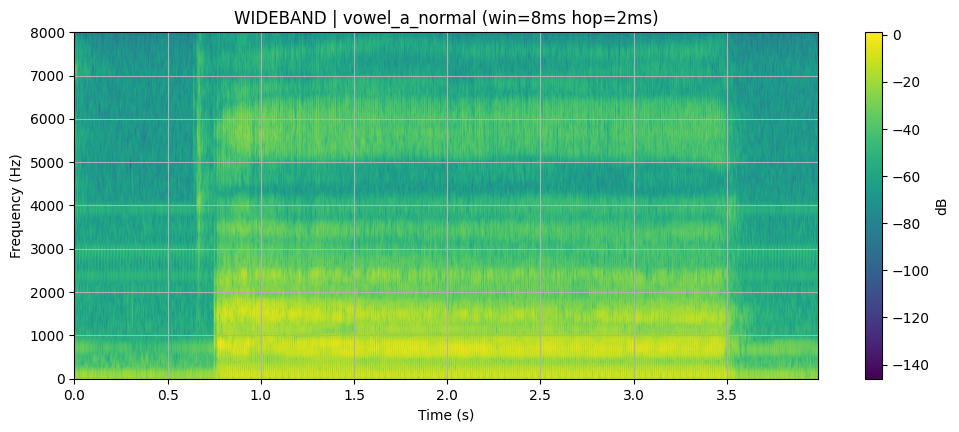

Saved figure -> EE519_L7_Project\figures\L7_4_fricative_wideband.png


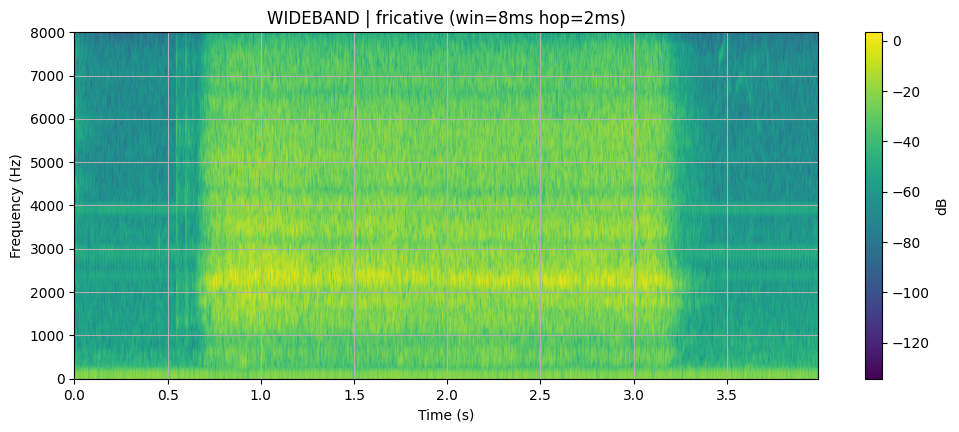

Saved figure -> EE519_L7_Project\figures\L7_4_stop_wideband.png


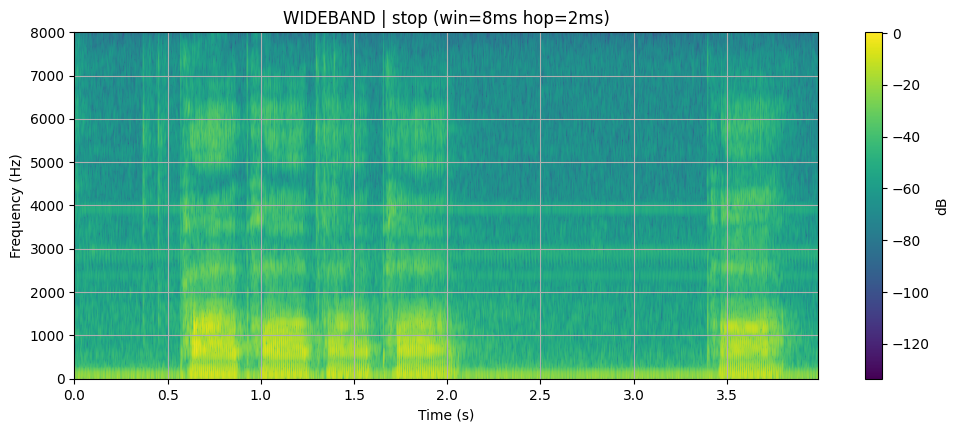

Saved figure -> EE519_L7_Project\figures\L7_4_sentence_normal_wideband.png


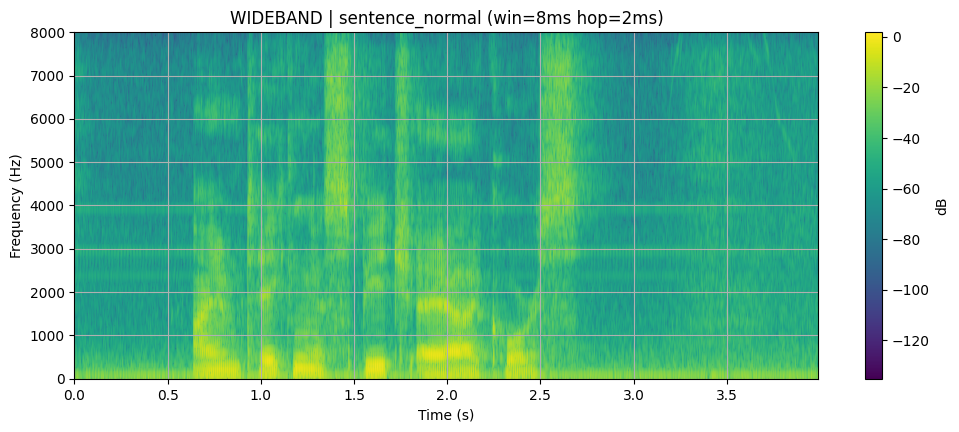

In [6]:
for c in clips:
    fs, y = load_wav(c["path"])
    f, tt, X, meta = stft_manual(y, fs, win_length_ms=8, hop_ms=2, window="hann", nfft=512, center=False)
    plot_spectrogram_db(f, tt, X,
                        title=f"WIDEBAND | {c['name']} (win=8ms hop=2ms)",
                        fmax=min(8000, fs/2),
                        save_as=f"L7_4_{c['name']}_wideband.png")


---
## 3) Narrowband (long window)
Recommended: win=40ms hop=10ms, nfft=2048


#### 🔍 Before you run: what will change when you change window/hop?
- **Short window** → better **time** resolution, blurrier frequency (wideband look)
- **Long window** → better **frequency** resolution, blurrier time (narrowband look)
- **Smaller hop** → more overlap → smoother time evolution, more computation

**Common issues**
- If harmonics look “fuzzy”: increase window length (for narrowband).
- If stop bursts look “smeared”: shorten window (for wideband).


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Saved figure -> EE519_L7_Project\figures\L7_4_vowel_a_normal_narrowband.png


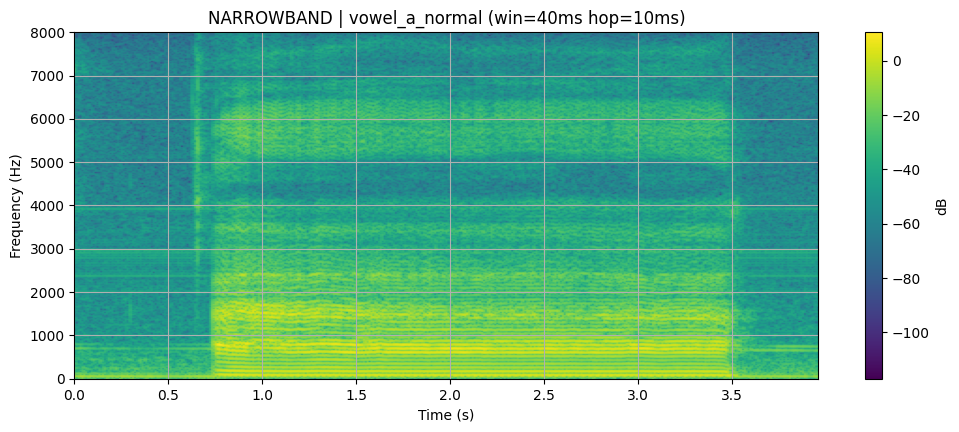

Saved figure -> EE519_L7_Project\figures\L7_4_fricative_narrowband.png


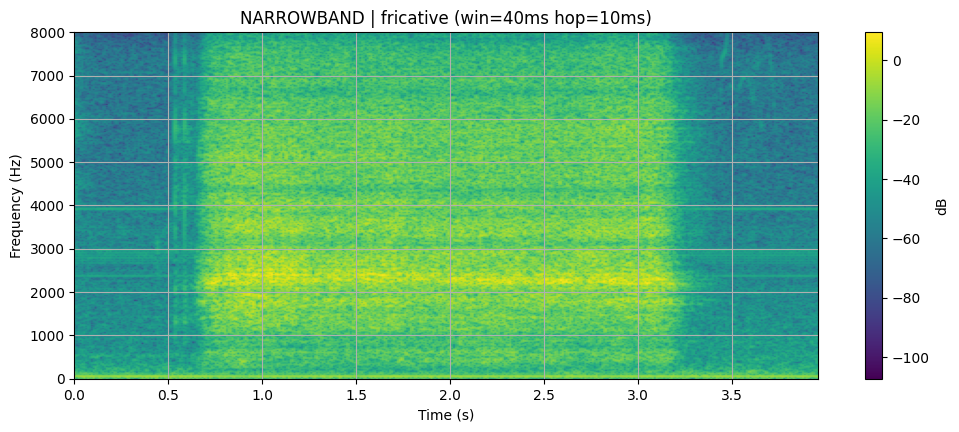

Saved figure -> EE519_L7_Project\figures\L7_4_stop_narrowband.png


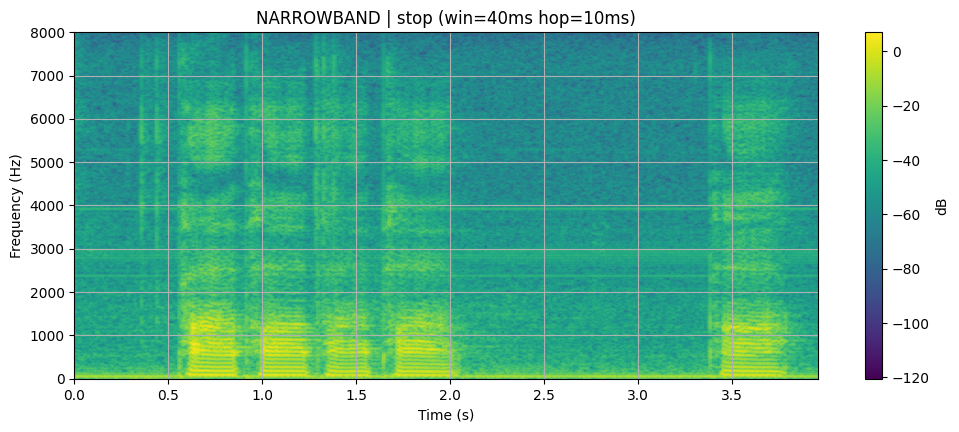

Saved figure -> EE519_L7_Project\figures\L7_4_sentence_normal_narrowband.png


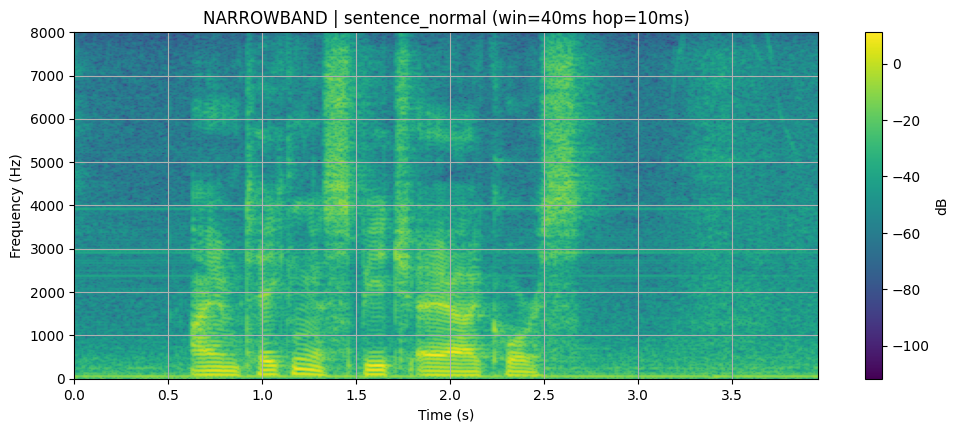

In [7]:
for c in clips:
    fs, y = load_wav(c["path"])
    f, tt, X, meta = stft_manual(y, fs, win_length_ms=40, hop_ms=10, window="hann", nfft=2048, center=False)
    plot_spectrogram_db(f, tt, X,
                        title=f"NARROWBAND | {c['name']} (win=40ms hop=10ms)",
                        fmax=min(8000, fs/2),
                        save_as=f"L7_4_{c['name']}_narrowband.png")


---
## 4) Guided interpretation prompts (answer in markdown)
For each clip, answer:
1) Is it mostly voiced, unvoiced, bursts, or mixed?
2) In wideband: where do you see bursts/onsets clearly?
3) In narrowband: where do you see harmonic lines / pitch?
4) Where is silence visible?

**Extra (fast vs slow):**
If you recorded fast vs slow sentences, compare how the spectrogram “density” changes.


### Answers

1. vowel_a_normal: voiced, fricative: unvoiced, stop: voiced, sentence_normal: mixed
2. The bursts and onsets are clearly seen in the stop and sentence along the time axis but not visible in the vowel and fricative.
3. The harmonics are seen towards the bottom in yellow lines for all clips except the fricative.
4. The silence is visible on the right and left sides since each clip started and ended with silence.

---
## 5) Lectures 7-8 wrap-up (required reflection)
Write a short “Lectures 7-8 summary” (in sentences):
- What is STFT conceptually?
- How does windowing affect leakage?
- What parameter choices worked best for your speech recordings and why?
- What is the difference between wideband and narrowband views?
- What questions do you still have?

### Next we will focus on:
- inverse STFT / overlap-add reconstruction
- magnitude vs phase experiments (intelligibility)


### Answers

- SFFT splits the signal into overlapping frames, applies a window to each frame, and computes the FFT on each window.
- Windowing smoothes the spectral leakages at the edges of each frame.
- 20-30 ms window sizes all worked equally well. The hann window was the best since I could see the harmonics and it also reduced leakage. The hop size of less than half the window size was the best.
- Wideband is a shorter window while narrowband is a larger one. Narrowband showed harmonics better but wideband showed onsets/stops better.
- My main questions are just about terms and visual examples of what to look for in the graphs. I think seeing more examples would be helpful to cement exactly what I'm looking at.

---
## ✅ End-of-notebook wrap-up 
**Reflection (write in sentences):**
- What parameter change produced the *biggest visible difference* today?
- Which plot helped you most: waveform, spectrum, or spectrogram — and why?
- Name one mistake you made (or could make) and how you would debug it.



### Answers

- The clips that I tried made a big difference.
- The spectrogram helped me find the harmonics to determine that its voiced.
- I picked the wrongs clips so I had to rerun the notebook.